In [1]:
# default_exp models


# models
> models to be used in contextual map solvers

## numerical

### nonlinear

In [68]:
#export 
import torch
from torch.autograd import Variable

class SimpleModel(torch.nn.Module):
    def __init__(self,num_input, num_hidden_units=100, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(num_input,num_hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_units,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [69]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [70]:
X = np.atleast_2d(np.linspace(-3,3,100)).T

y = np.sin(X) + np.random.normal(1)

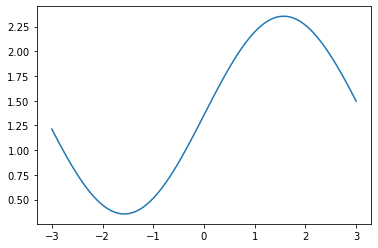

In [71]:
plt.plot(X,y)

In [72]:
sm = SimpleModel(1)

In [73]:
y_hat = sm(X)

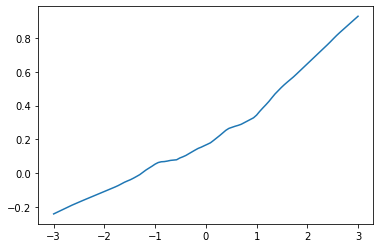

In [74]:
plt.plot(X,y_hat.detach())

In [75]:
epochs = 10000

optimizer = torch.optim.SGD(
            sm.parameters(),
            weight_decay=0.01,
            lr=0.001)
criterion = torch.nn.MSELoss()
y = Variable(torch.Tensor(y), requires_grad=False)

for i in range(epochs):
    y_pred = sm(X)
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

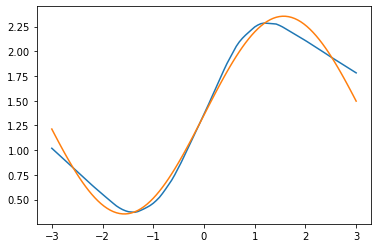

In [76]:
y_hat = sm(X)
plt.plot(X,y_hat.detach())
plt.plot(X,y)